# Local Feature Matching

## Table of Contents:
### Harris Corner Detector  
1. Compute image gradients.
2. Get the 2D gaussian kernel by pytorch.
3. Compute harris response map.
4. Compute Maxpool.
5. Remove Bordget Harris interest points.

### SIFT  
1. Get magnitudes and orientations of images.
2. Get gradient of histogram vectors.
3. Get feat vectors.
4. Get SIFT descriptors. 

### Feature Matching
1. Compute the feature distances, provide SIFT, show output image, note they use sift descriptors
2. Compute the match features ratio


## Set up
The below cell loads and displays images on which we will try to match features.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


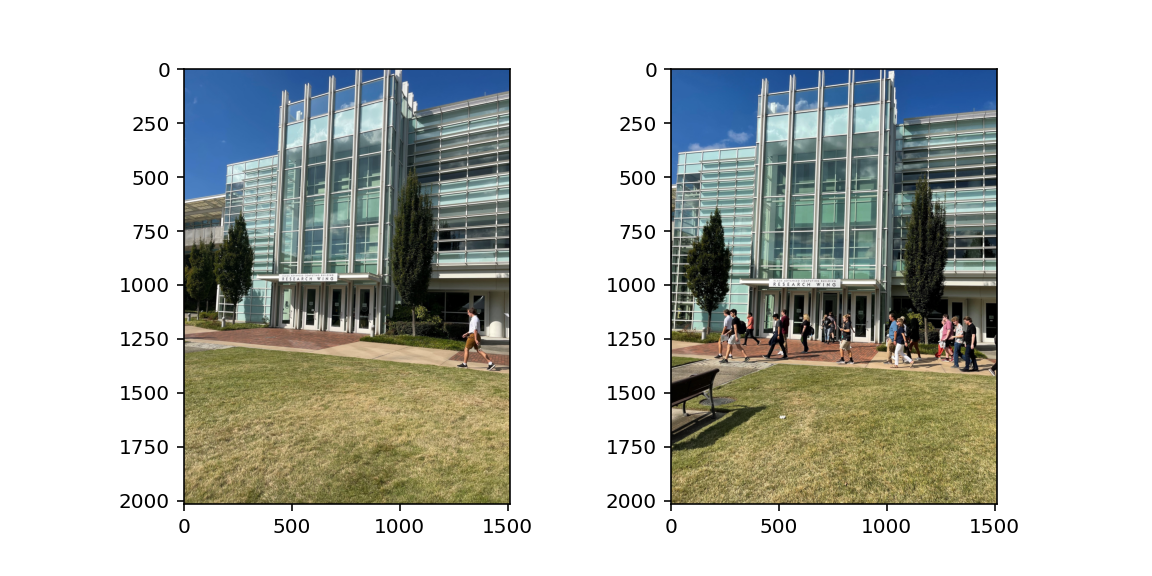

In [88]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch

from utils import load_image, PIL_resize, rgb2gray, normalize_img, verify
from IPython.core.debugger import set_trace


# Building
image1 = load_image('../data/2a_building.jpg')
image2 = load_image('../data/2b_building.jpg')

#Notredame
#image1 = load_image('../data/1a_hongya.jpg')
#image2 = load_image('../data/1b_hongya.jpg')

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))
image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)


# Harris Corner Detector 


The Harris corner detector and SIFT rely heavily upon image gradient information. 

compute_image_gradients():  "Correct"


<IPython.core.display.Javascript object>


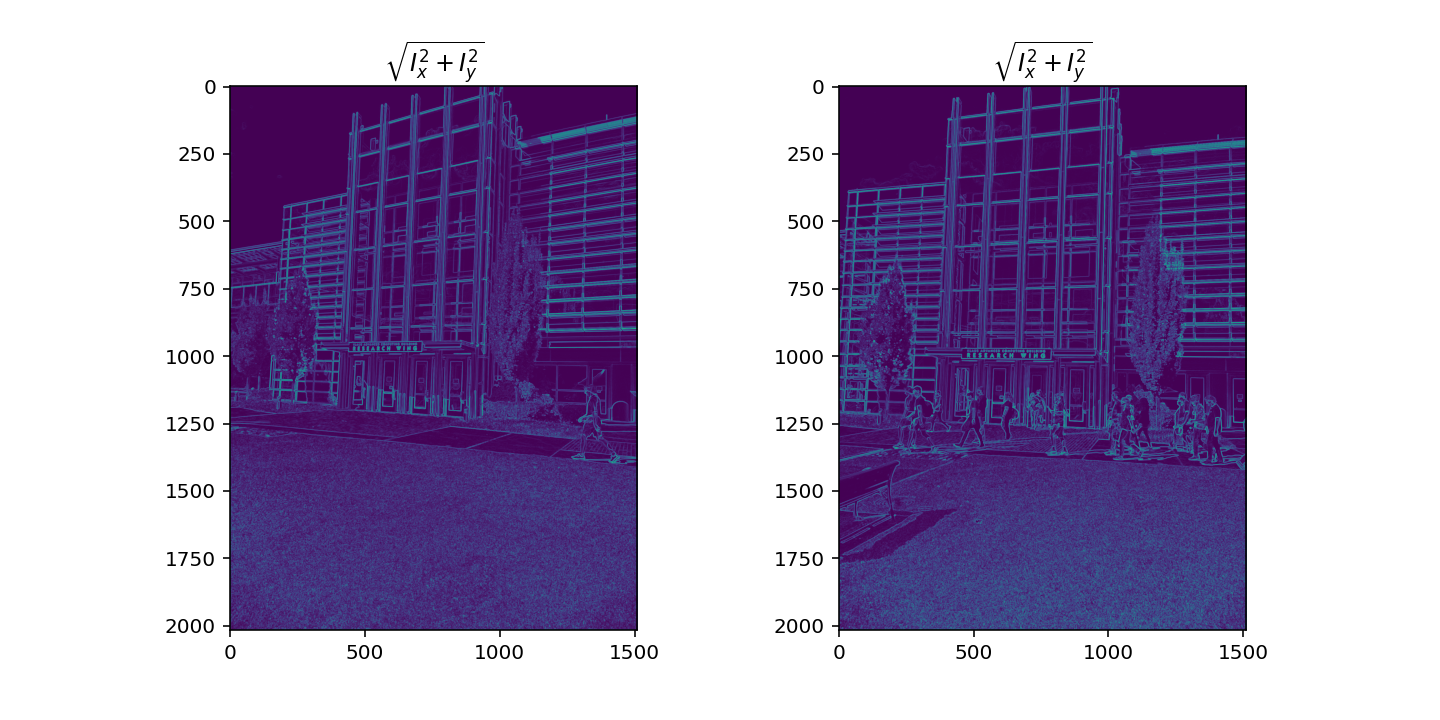

In [89]:
from matching import compute_image_gradients
import torch

plt.figure(figsize=(10,5))
plt.axis('off')


Ix, Iy = compute_image_gradients(torch.from_numpy(image1_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,1)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

torch.from_numpy(image2_bw)
Ix, Iy = compute_image_gradients(torch.from_numpy(image2_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,2)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))


In [90]:
print(gradient_magnitudes)

[[3.49224597e-01 3.29693556e-01 3.29274178e-01 ... 2.76690066e-01
  2.77066141e-01 2.93873012e-01]
 [3.30677569e-01 3.79406242e-03 3.36717581e-03 ... 2.78086518e-03
  7.31737604e-09 2.77066141e-01]
 [3.32603216e-01 4.32516029e-03 4.10262356e-03 ... 8.52368306e-04
  1.15157210e-03 2.76779592e-01]
 ...
 [5.32385528e-01 1.62747815e-01 1.05305746e-01 ... 9.94307101e-02
  1.97149888e-02 6.15000904e-01]
 [5.68765640e-01 1.44340634e-01 5.65460697e-02 ... 7.43393153e-02
  5.25758527e-02 6.34570062e-01]
 [5.89046061e-01 5.90349793e-01 6.27997041e-01 ... 6.43321931e-01
  6.39365256e-01 6.78724885e-01]]


### Get gaussian kernel

We'll now compute the second moments $s_x^2, s_y^2, s_x s_y$ at each pixel, which aggregates gradient information in local neighborhoods. We'll use a 2d Gaussian filter to aggregate:

In [72]:
from matching import second_moments
import torch

sx2, sy2, sxsy = second_moments(torch.from_numpy(image1_bw), ksize = 7, sigma = 10)
sx2 = sx2.numpy()
sy2 = sy2.numpy()
sxsy = sxsy.numpy()

get_gaussian_kernel_2D_pytorch_peak(): "Correct"
get_gaussian_kernel_2D_pytorch_sumsto1(): "Correct"
get_gaussian_kernel_2D_pytorch(): "Correct"
second_moments(): "Correct"


If we compare $s_x^2$, $s_y^2$, and $s_x s_y$ with $I_x$ and $I_y$, we see:

<IPython.core.display.Javascript object>


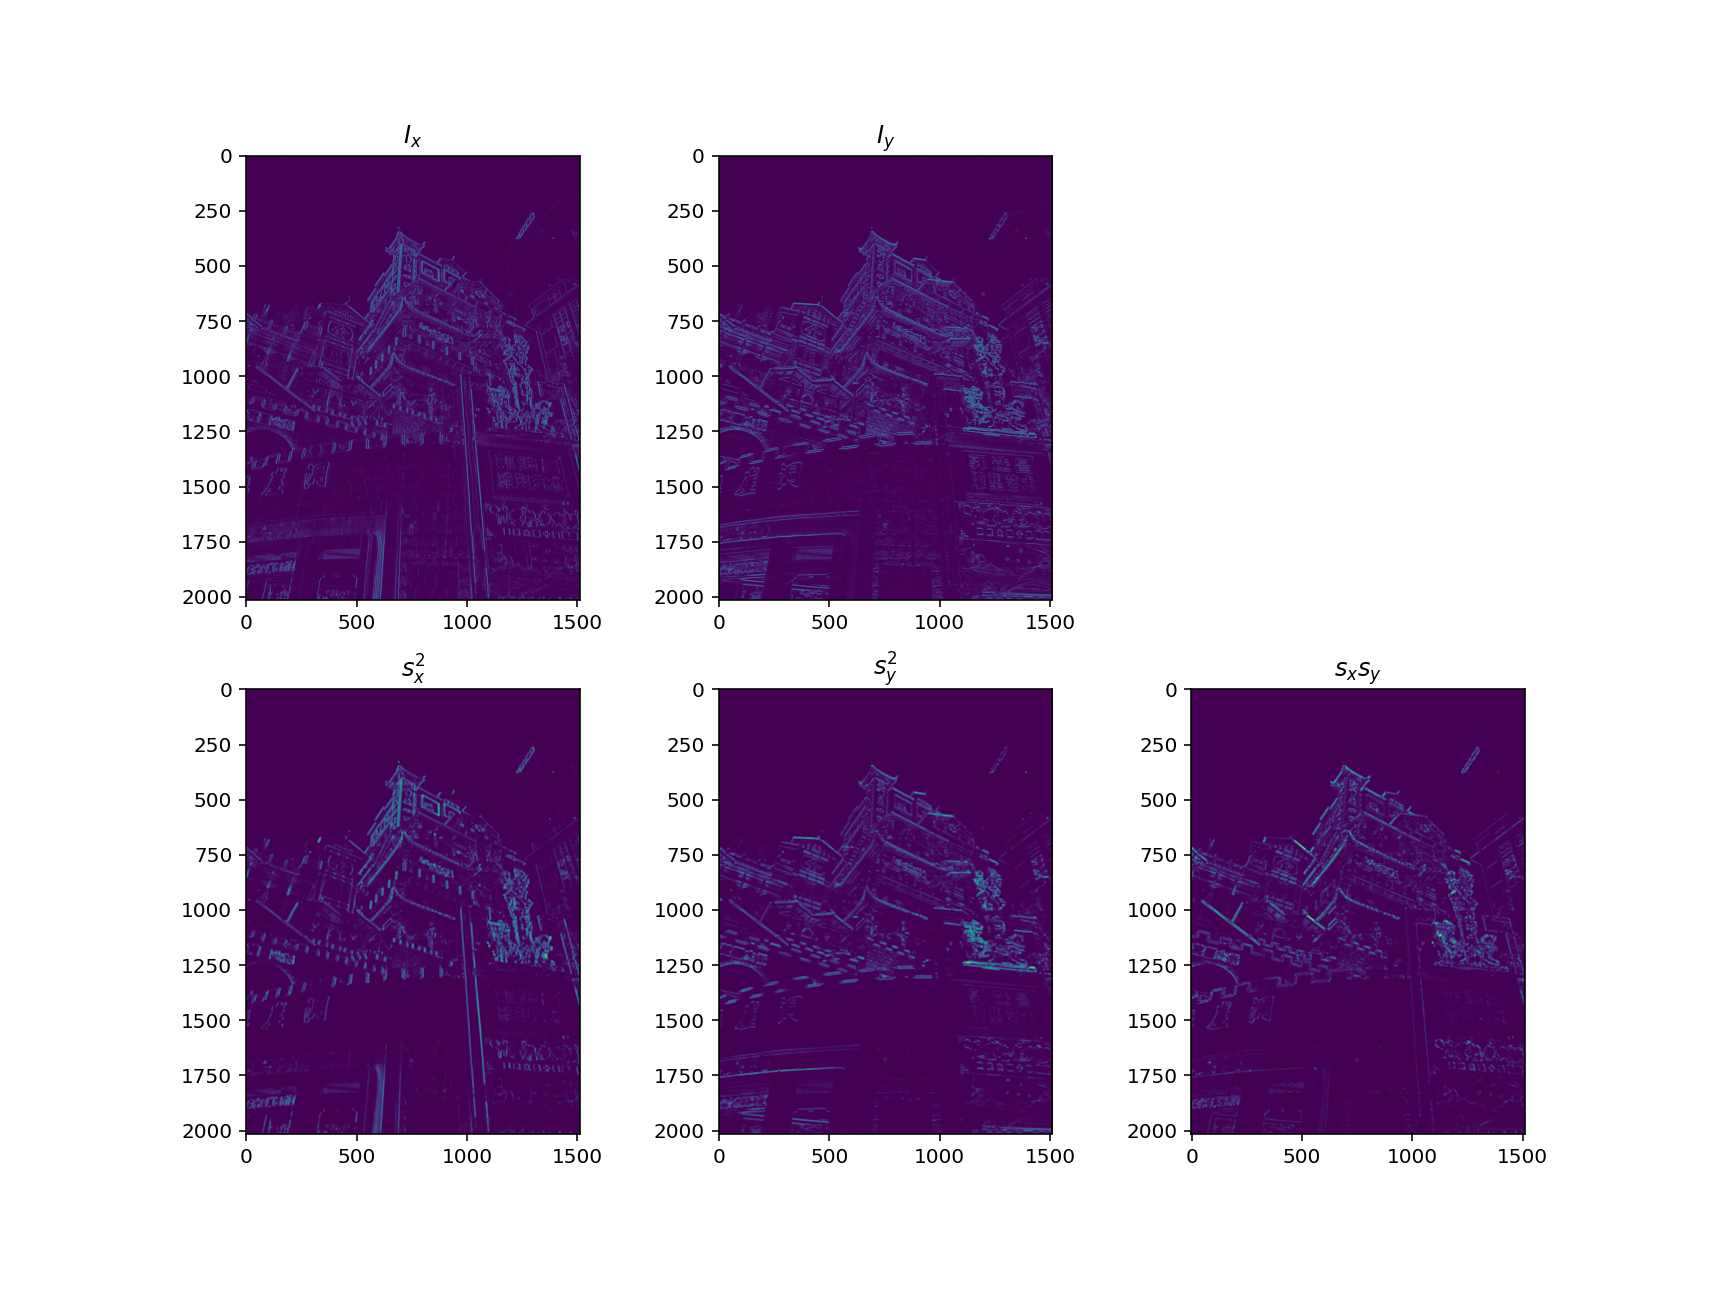

In [74]:
from utils import normalize_img

plt.figure(figsize=(12,9))
Ix, Iy = compute_image_gradients(torch.from_numpy(image1_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
plt.subplot(2,3,1); plt.title(r'$I_x$')
plt.imshow( (normalize_img(np.abs(Ix))*255).astype(np.uint8))
plt.subplot(2,3,2); plt.title(r'$I_y$')
plt.imshow( (normalize_img(np.abs(Iy))*255).astype(np.uint8))

plt.subplot(2,3,4)
plt.title(r'$s_x^2$')
plt.imshow( (normalize_img(np.abs(sx2))*255).astype(np.uint8))

plt.subplot(2,3,5)
plt.title(r'$s_y^2$')
plt.imshow( (normalize_img(np.abs(sy2))*255).astype(np.uint8))

plt.subplot(2,3,6)
plt.title(r'$s_xs_y$')
plt.imshow( (normalize_img(np.abs(sxsy))*255).astype(np.uint8))

### Compute Harris response map

Note that $s_xs_y$ is highest where there are both strong x-direction and y-direction gradients (corners and the central rose window).

We'll now use these second moments to compute a "cornerness score" -- a corner response map -- as a function of these image gradients.

compute_harris_response_map():  "Correct"


<IPython.core.display.Javascript object>


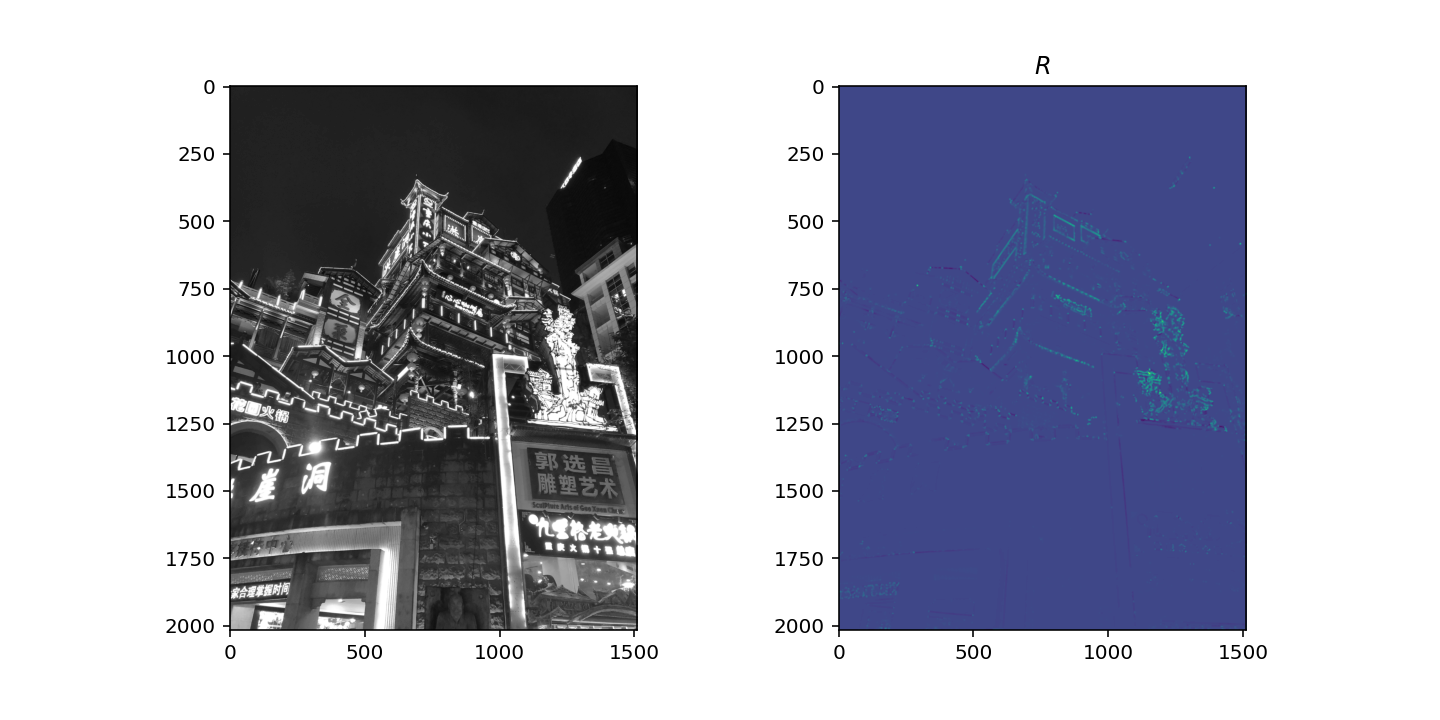

In [75]:
from matching import compute_harris_response_map

R = compute_harris_response_map(torch.from_numpy(image1_bw))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image1_bw, cmap='gray')
plt.subplot(1,2,2)
plt.title(r'$R$')
plt.imshow(R)

### Maxpool
In order to find local maxima in the 2d response max we can simply pick a local maximum over some window size (u, v). This non-maximum suppression can be achieved using max-pooling. We can see a visualization of how this process works below. On the left is the image, on the right is the result of the max-pooling.
![image and maxpool](notebookimages/maxpoolexample.png "Image on left, max-pool result on right")


maxpool_numpy():  "Correct"


<IPython.core.display.Javascript object>


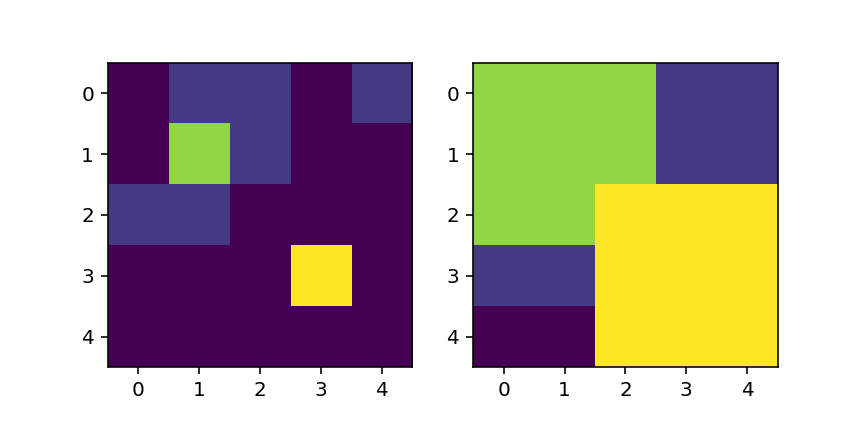

In [76]:
from matching import maxpool_numpy
from utils import verify

toy_response_map = np.array(
[
    [1,2,2,1,2],
    [1,6,2,1,1],
    [2,2,1,1,1],
    [1,1,1,7,1],
    [1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(toy_response_map.astype(np.uint8))

plt.subplot(1,2,2)

maxpooled_image = maxpool_numpy(torch.from_numpy(toy_response_map), ksize=3)
maxpooled_image = maxpooled_image.numpy()

plt.imshow(maxpooled_image.astype(np.uint8))

Given a simple 5x5 grid of response scores, non-max suppression will allow us to choose values that are local maxima. If we request the top $k=2$ responses of the toy response grid above, we should get (1,1) and (3,3)

In [77]:
from matching import nms_maxpool_pytorch

x_coords, y_coords, confidences = nms_maxpool_pytorch(torch.from_numpy(toy_response_map), k=2, ksize=3)
x_coords = x_coords.numpy()
y_coords = y_coords.numpy()
confidences = confidences.numpy()
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')

nms_maxpool_pytorch():  "Correct"
Coordinates of local maxima:
	At 3,3, local maximum w/ confidence=7.00
	At 1,1, local maximum w/ confidence=6.00


### Remove border values and get Harris interest points
Detect 'interesting' points and see the interest points of images.

<IPython.core.display.Javascript object>


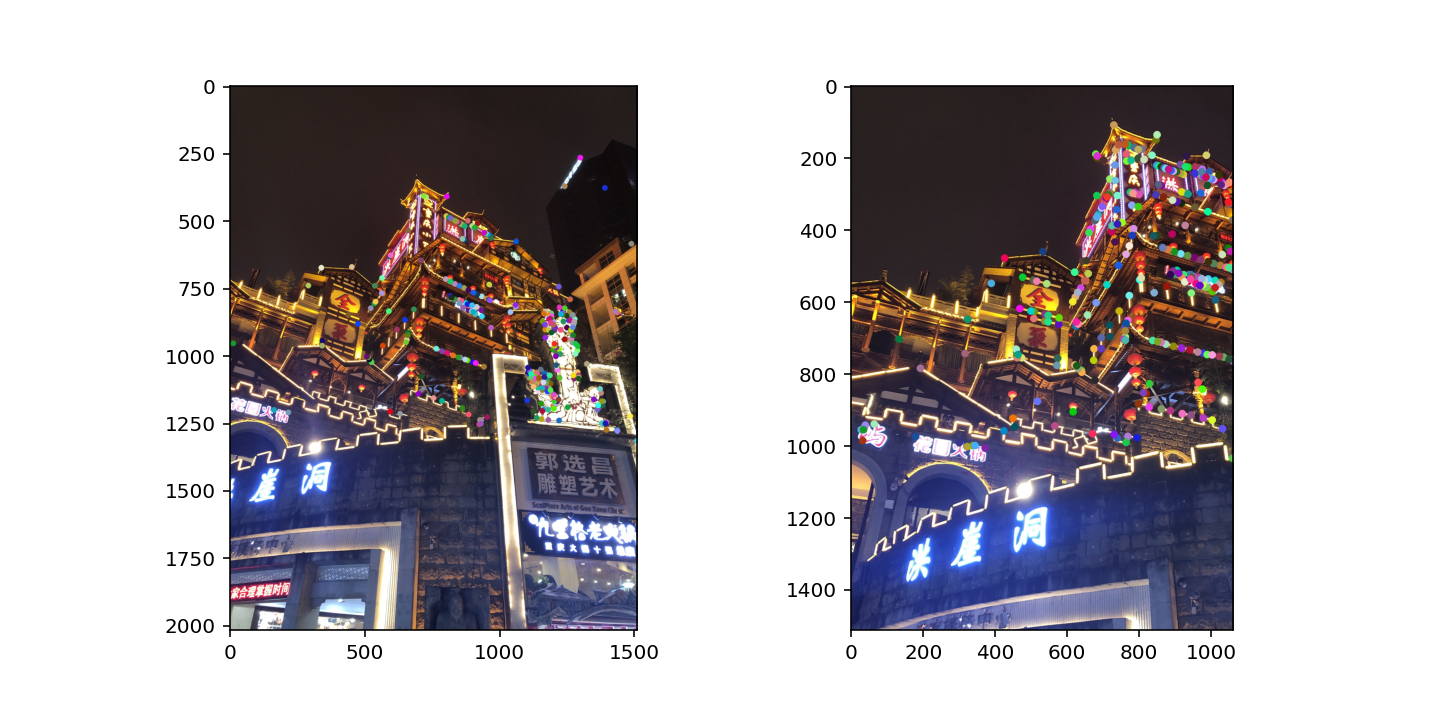

2068 corners in image 1, 2158 corners in image 2


In [79]:
import copy
from matching import get_harris_interest_points
from utils import show_interest_points
import torch

num_interest_points = 2500
X1, Y1, _ = get_harris_interest_points( torch.from_numpy(copy.deepcopy(image1_bw)), num_interest_points)
X2, Y2, _ = get_harris_interest_points( torch.from_numpy(copy.deepcopy(image2_bw)), num_interest_points)
X1 = X1.numpy()
X2 = X2.numpy()
Y1 = Y1.numpy()
Y2 = Y2.numpy()

num_pts_to_visualize = 300
# Visualize the interest points
rendered_img1 = show_interest_points(image1, X1[:num_pts_to_visualize], Y1[:num_pts_to_visualize])
rendered_img2 = show_interest_points(image2, X2[:num_pts_to_visualize], Y2[:num_pts_to_visualize])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rendered_img1)
plt.subplot(1,2,2); plt.imshow(rendered_img2)
print(f'{len(X1)} corners in image 1, {len(X2)} corners in image 2')

# Sift Feature Descriptor
SIFT relies upon computing the magnitudes and orientations of image gradients, and then computing weighted histograms.

### Get magnitudes and orientations
These will be used to calculate the gradient histogram vectors for each patch.

### Get gradient of histogram vectors
This function takes in (16,16) arrays representing the magnitudes and orientations of a given patch. For each 4x4 possible "cell" in the 16x16 patch, compute the histogram of the distribution of gradients in 8 orientations. 


### Get feat vectors.
This function takes in an interest point and the magnitudes and orientations of the entire image, then calls the previously written function to get the gradient histogram, passing in the appropriate section of the magnitudes and orientations. Finally, it should normalize the returned gradient histogram (divide by the norm) then square root it as described in [here](https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf) for a performance boost.


### Get SIFT descriptors
This function is passed an image and an array of x values of interest points and y values of interest points (`compute_image_gradients()`). It should first compute the gradients (Ix and Iy) of the image(`get_magnitudes_and_orientations()`), then use these to get the magnitude and orientation at each point. Then, for each x, y pair get the feature vector around it (`get_feat_vec()`).  


SIFT took 12.41189980506897 sec.


<IPython.core.display.Javascript object>


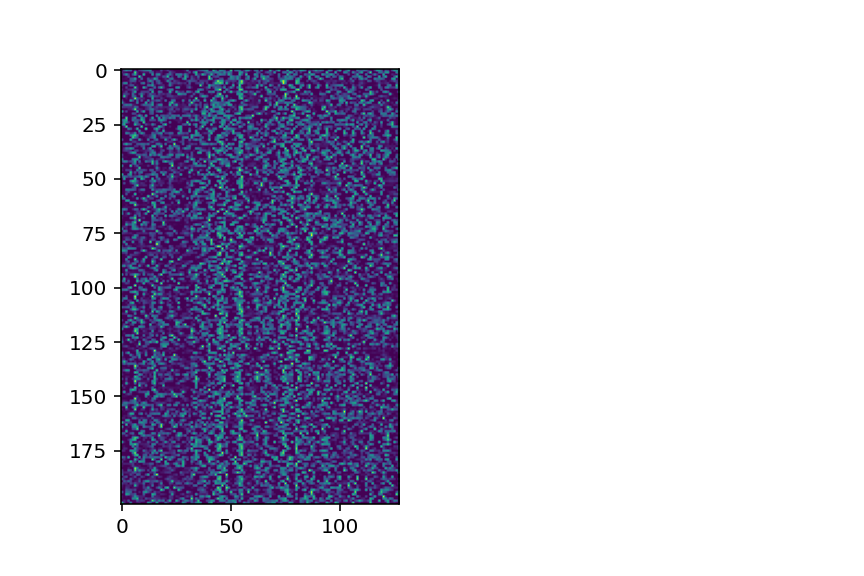

In [84]:
from matching import get_SIFT_descriptors
from utils import cheat_interest_points

import time
start = time.time()

image1_features = get_SIFT_descriptors(torch.from_numpy(image1_bw), torch.from_numpy(X1), torch.from_numpy(Y1))
image2_features = get_SIFT_descriptors(torch.from_numpy(image2_bw), torch.from_numpy(X2), torch.from_numpy(Y2))
image1_features = image1_features.numpy()
image2_features = image2_features.numpy()
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

# visualize what the values of the first 200 SIFT feature vectors look like (should not be identical or all black)
plt.figure(); plt.subplot(1,2,1); plt.imshow(image1_features[:200])

# Match features

Now that we have implemented our SIFT descriptors, we can start trying to match features between images:

Implement the ratio test show below in `match_features_ratio_test` in `matching.py`. Set a threshold for NNDR (.75 is a decent baseline). 
$||D_A - D_B||$ is distance between Descriptor A and its closest match. $||D_A - D_C||$ is distance between Descriptor A and its second closest match. 

![ratio test equation](notebookimages/ratiotest.PNG)


In [86]:
from matching import match_features_ratio_test

matches, confidences = match_features_ratio_test(torch.from_numpy(image1_features), torch.from_numpy(image2_features))
matches = matches.numpy()
confidences = confidences.numpy()
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

627 matches from 2068 corners


## Visualization

627 matches from 2068 corners


<IPython.core.display.Javascript object>


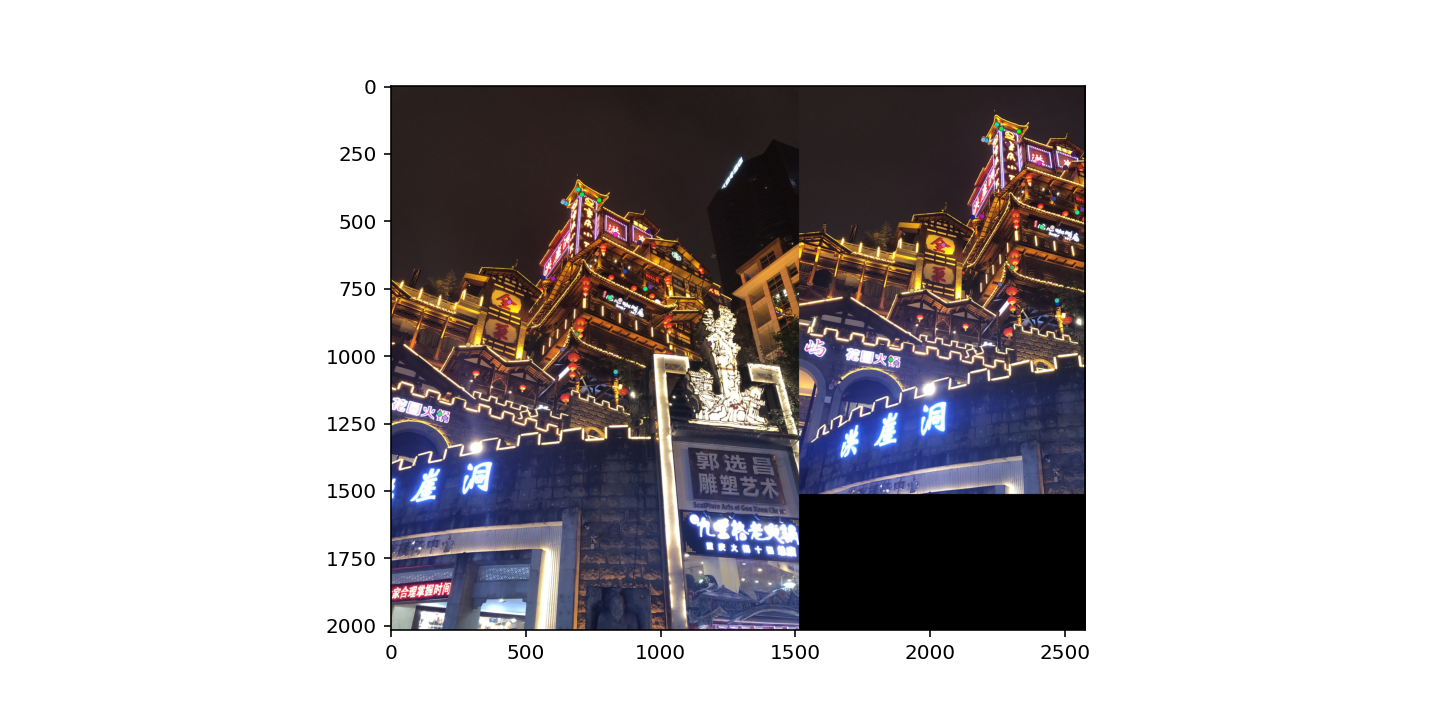

<IPython.core.display.Javascript object>


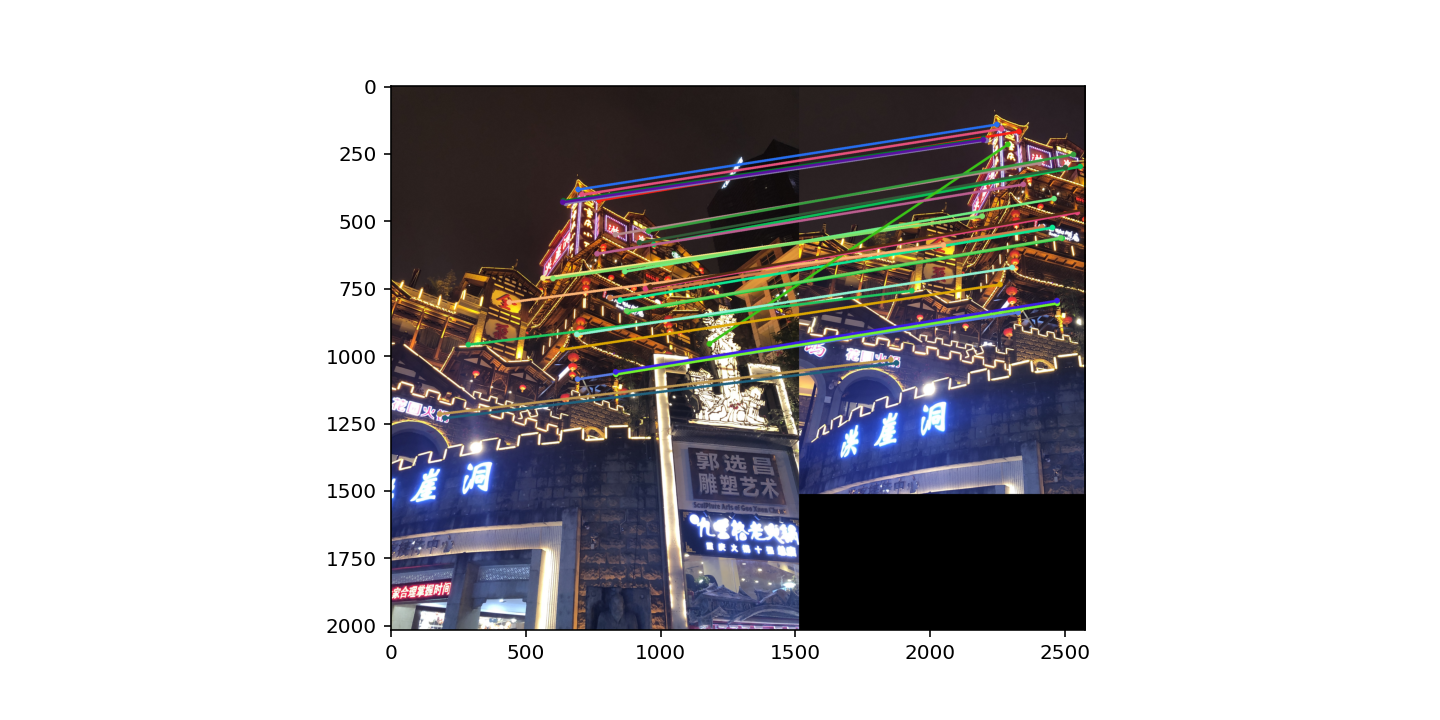

In [87]:
from utils import show_correspondence_circles, show_correspondence_lines
import os
os.makedirs('../results', exist_ok=True)

matches, confidences = match_features_ratio_test(torch.from_numpy(image1_features), torch.from_numpy(image2_features))
matches = matches.numpy()
confidences = confidences.numpy()
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 30
c1 = show_correspondence_circles(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)